In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta

## データの読み込み

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
display(df_train.head())
display(df_test.head())

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


,datetime,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-10-1,水,1,メンチカツ,420.0,NaN,NaN,NaN,雨,0,20.2
1,2014-10-2,木,0,バーベキューチキン,415.0,NaN,NaN,NaN,曇,--,23.9
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,NaN,NaN,NaN,晴れ,--,28.7
3,2014-10-6,月,1,麻婆春雨,400.0,NaN,NaN,NaN,雨,0.5,21.5
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,NaN,NaN,NaN,晴れ,--,22.1


## trainとtestは結合して処理する
- メニューやイベントにおいてどちらかにないというのにフラグがたてられないため

In [4]:
df_train.loc[:, "data_flg"] = 1
df_test.loc[:, "data_flg"] = 0
df_test.loc[:, "y"] = np.nan
df_test = df_test[df_train.columns]

In [5]:
dataset_df = pd.concat([df_train, df_test])

## 時間の処理をしておく

In [6]:
dataset_df["datetime"] = pd.to_datetime(dataset_df["datetime"])

## カテゴリ化する

In [7]:
def make_dummies(df_c):
    source = df_c.copy()
    dummy_df = pd.DataFrame([])
    dummy_col = ["week", "remarks", "event"]
    for col in dummy_col:
        dummy = pd.get_dummies(df_c[col])
        dummy_df = pd.concat([dummy_df, dummy], axis=1)
    source = source.drop(dummy_col, axis = 1)
    
    return pd.concat([source, dummy_df], axis=1)

In [8]:
dataset_df = make_dummies(dataset_df)

## 天気を数値へ変換する
|天気コード|天気|
|-------|----|
|快晴|1|
|晴れ|2|
|薄曇|3|
|曇  |4|
|雨  |5|
|雪  |6|
|雷電 |7|

In [9]:
weather_dict = {"快晴":1, "晴れ":2, "薄曇":3, "曇":4, "雨":5, "雪":6, "雷電":7}

In [10]:
dataset_df["weather"] = dataset_df["weather"].map(lambda x: weather_dict[x])

## 降水量の置換

In [11]:
dataset_df["precipitation"] = dataset_df["precipitation"].map(lambda x: 0 if x=="--" else x)

In [12]:
dataset_df.to_csv("dataset_df.csv", index=False)

## 給料日の経過日数

In [13]:
pay_df = pd.read_csv("給料日日付データ.csv")

In [14]:
pay_df["datetime"] = pd.to_datetime(pay_df["datetime"])
pay_df["経過終了日"] = pay_df["datetime"]
pay_df = pay_df.set_index("datetime")
pay_day = pay_df[pay_df["給料日"] == 1]
pay_day["経過開始日"] = pay_day["経過終了日"].shift()
pay_day["経過終了日"] = pay_day["経過終了日"] - timedelta(days=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
keika_df = pd.DataFrame([])
for d in pay_day[["経過開始日", "経過終了日"]].values:
    temp = pay_df[d[0]: d[1]].reset_index(drop=False).reset_index(drop=False)
    temp = temp[["datetime","index"]]
    keika_df = pd.concat([keika_df, temp])
keika_df = keika_df.rename(columns={"index": "給料日経過日数"})
keika_df["給料日経過日数"] = keika_df.loc[:, "給料日経過日数"] + 1

In [16]:
keika_df.head()

,datetime,給料日経過日数
0,2013-11-08,1
1,2013-11-09,2
2,2013-11-10,3
3,2013-11-11,4
4,2013-11-12,5


In [17]:
dataset_df = pd.merge(dataset_df, keika_df, how="left", on="datetime")
dataset_df = dataset_df.drop("payday", axis=1)

## kcalの欠損を埋める

In [18]:
menu_df = pd.read_csv("メニュー分類.csv")
menu_columns = list(menu_df.columns)
menu_ = list(menu_df.columns)
menu_.remove("name")
menu_columns.append("kcal")

In [19]:
#おいちゃん特性のメニュー分類の結合
dataset_df = pd.merge(dataset_df, menu_df, how="left", on="name")

In [20]:
# 欠損と欠損じゃないのを分ける
no_missing_tf = dataset_df["kcal"] == dataset_df["kcal"]
no_missing_data = dataset_df[no_missing_tf]
missing_data = dataset_df[~no_missing_tf]
print ("欠損メニュー数：",missing_data["kcal"].isnull().sum())

欠損メニュー数： 45


#### 欠損を除外してkcalの平均を算出
#### 重複メニューにkcalが入っていた場合はそれを使う

In [21]:
equal_name_kcal_dict = pd.DataFrame(no_missing_data.groupby("name").mean()["kcal"]).to_dict()

In [22]:
for i in equal_name_kcal_dict["kcal"].keys():
    missing_data.loc[missing_data["name"] == i, "kcal"] = equal_name_kcal_dict["kcal"][i]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
print ("欠損メニュー数：",missing_data["kcal"].isnull().sum())

欠損メニュー数： 33


#### その他はおいちゃん特性のメニュー分類で埋める

In [24]:
for i in menu_:
    equal_menu_mean = no_missing_data[no_missing_data[i] == 1]["kcal"].mean()
    print ("メニュー：{0} {1}".format(i, equal_menu_mean))
    missing_data.loc[(missing_data[i] == 1) & (missing_data["kcal"].isnull()), "kcal"] = equal_menu_mean

メニュー：カツ 411.10714285714283
メニュー：カレー 410.0
メニュー：ハンバーグ 408.8333333333333
メニュー：中華 405.0408163265306
メニュー：フライ 422.0
メニュー：チキン 408.1666666666667
メニュー：その他 406.0813953488372


In [25]:
print ("欠損メニュー数：",missing_data["kcal"].isnull().sum())

欠損メニュー数： 0


In [26]:
fin_dataset = pd.concat([no_missing_data, missing_data])

In [27]:
fin_dataset = fin_dataset.sort_values("datetime")

In [28]:
fin_dataset.to_csv("dataset_df.csv", index=False)

## 後処理

In [29]:
fin_train_data = fin_dataset[fin_dataset["data_flg"] == 1].reset_index(drop=True)
fin_train_data = fin_train_data.drop(["name", "data_flg"], axis=1)
fin_test_data = fin_dataset[fin_dataset["data_flg"] == 0].reset_index(drop=True)
fin_test_data = fin_test_data.drop(["name", "data_flg", "y"], axis=1)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train_data, val_data = train_test_split(fin_train_data, test_size=0.2, shuffle=False)

In [32]:
print (train_data.shape)
print (val_data.shape)
print (fin_test_data.shape)

(165, 29)
(42, 29)
(40, 28)


In [33]:
train_data.to_csv("output_train_data.csv", index=False)
val_data.to_csv("output_val_data.csv", index=False)
fin_test_data.to_csv("output_test_data", index=False)

## カレンダーデータの作成

In [34]:
import jpholiday
import datetime

In [35]:
jp_calendar_data = pd.DataFrame(index=pd.date_range(start='2013-11-4', end='2014-12-15', freq='1D'))

In [36]:
jp_calendar_data.index

DatetimeIndex(['2013-11-04', '2013-11-05', '2013-11-06', '2013-11-07',
               '2013-11-08', '2013-11-09', '2013-11-10', '2013-11-11',
               '2013-11-12', '2013-11-13',
               ...
               '2014-12-06', '2014-12-07', '2014-12-08', '2014-12-09',
               '2014-12-10', '2014-12-11', '2014-12-12', '2014-12-13',
               '2014-12-14', '2014-12-15'],
              dtype='datetime64[ns]', length=407, freq='D')

曜日

In [37]:
jp_calendar_data['day_of_the_week'] = jp_calendar_data.index.map(lambda x: x.weekday_name)

休日フラグ

In [38]:
jp_calendar_data['holiday_flg'] = jp_calendar_data.index.map(lambda x: 1 if jp_calendar_data['day_of_the_week'][x] in ['Saturday', 'Sunday']  or jpholiday.is_holiday(x) else 0)

休日名

In [39]:
jp_calendar_data['holiday_name'] = jp_calendar_data.index.map(lambda x: jpholiday.is_holiday_name(x))

休日からの経過日数

In [40]:
jp_calendar_data['days_from_last_holiday'] = pd.Series()
passed_days = 0
for idx in jp_calendar_data.index:
    if jp_calendar_data['holiday_flg'][idx]:
        passed_days = 0
    jp_calendar_data['days_from_last_holiday'][idx] = passed_days
    passed_days += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
jp_calendar_data['days_of_consecutive_holidays'] = pd.Series()
passed_days = 0
for idx in jp_calendar_data.index:
    if jp_calendar_data['holiday_flg'][idx]:
        passed_days += 1
        jp_calendar_data['days_of_consecutive_holidays'][idx] = passed_days
    else:
        passed_days = 0
        jp_calendar_data['days_of_consecutive_holidays'][idx] = passed_days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [42]:
jp_calendar_data.head()

,day_of_the_week,holiday_flg,holiday_name,days_from_last_holiday,days_of_consecutive_holidays
2013-11-04,Monday,1,文化の日 振替休日,0.0,1.0
2013-11-05,Tuesday,0,None,1.0,0.0
2013-11-06,Wednesday,0,None,2.0,0.0
2013-11-07,Thursday,0,None,3.0,0.0
2013-11-08,Friday,0,None,4.0,0.0


csvに保存

In [43]:
jp_calendar_data.to_csv("./jp_calendar_data.csv")

# 予測

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas_profiling as pdp
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from IPython.core.display import display, HTML

### データの読み込み

In [45]:
train_data = pd.read_csv("./output_train_data.csv")
val_data = pd.read_csv("./output_val_data.csv")

train_data = train_data.set_index('datetime').sort_index()
val_data = val_data.set_index('datetime').sort_index()

In [46]:
jp_calendar_data = pd.read_csv("./jp_calendar_data.csv", index_col=0)
jp_calendar_data.index = pd.to_datetime(jp_calendar_data.index)

時間をインデックスにする

In [47]:
train_data.head()

,y,soldout,kcal,weather,precipitation,temperature,月,木,水,火,...,キャリアアップ支援セミナー,ママの会,給料日経過日数,カツ,カレー,ハンバーグ,中華,フライ,チキン,その他
datetime,,,,,,,,,,,,,,,,,,,,,
2013-11-18,90.0,0,422.000000,1,0.0,19.8,1,0,0,0,...,0,0,11,0,0,0,0,1,0,0
2013-11-19,101.0,1,411.107143,1,0.0,17.0,0,0,0,1,...,0,0,12,1,0,0,0,0,0,0
2013-11-20,118.0,0,405.040816,1,0.0,15.5,0,0,1,0,...,0,0,13,0,0,0,1,0,0,0
2013-11-21,120.0,1,405.040816,1,0.0,15.2,0,1,0,0,...,0,0,14,0,0,0,1,0,0,0
2013-11-22,130.0,1,411.107143,1,0.0,16.1,0,0,0,0,...,0,0,15,1,0,0,0,0,0,0


In [48]:
jp_calendar_data = jp_calendar_data.drop(['day_of_the_week', 'holiday_name'], axis=1)

In [49]:
jp_calendar_data.head()

,holiday_flg,days_from_last_holiday,days_of_consecutive_holidays
2013-11-04,1,0.0,1.0
2013-11-05,0,1.0,0.0
2013-11-06,0,2.0,0.0
2013-11-07,0,3.0,0.0
2013-11-08,0,4.0,0.0


### カレンダーデータをマージする

In [50]:
train_data_merged = pd.merge(train_data, jp_calendar_data, left_index=True, right_index=True)
val_data_merged = pd.merge(val_data, jp_calendar_data, left_index=True, right_index=True)

In [51]:
train_data_merged.to_csv("train_data_merged.csv")
val_data_merged.to_csv("val_data_merged.csv")

In [52]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

### 説明変数と目的変数を分離する。

In [53]:
features = train_data_merged.columns[train_data_merged.columns!='y'] # 説明変数
X_train_data = train_data_merged[features]
y_train_data = train_data_merged['y'].copy()

In [54]:
X_val_data = val_data_merged[features]
y_val_data = val_data_merged['y'].copy()

In [55]:
X_val_data.head()

,soldout,kcal,weather,precipitation,temperature,月,木,水,火,金,...,カツ,カレー,ハンバーグ,中華,フライ,チキン,その他,holiday_flg,days_from_last_holiday,days_of_consecutive_holidays
2014-07-28,1,432.0,2,0,28.9,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1.0,0.0
2014-07-29,0,449.0,2,0,30.4,0,0,0,1,0,...,0,0,0,0,0,1,0,0,2.0,0.0
2014-07-30,0,441.0,2,0,30.6,0,0,1,0,0,...,1,0,0,0,0,0,0,0,3.0,0.0
2014-07-31,0,386.0,2,0,32.5,0,1,0,0,0,...,0,0,0,0,0,0,1,0,4.0,0.0
2014-08-01,0,380.0,3,0,32.7,0,0,0,0,1,...,0,0,0,0,0,0,1,0,5.0,0.0


説明変数を標準化する

In [56]:
scaler = StandardScaler()
scaler.fit(X_train_data)
X_train_data_scaled = pd.DataFrame(scaler.transform(X_train_data), columns=X_train_data.columns)
X_val_data_scaled = pd.DataFrame(scaler.transform(X_val_data), columns=X_val_data.columns)

In [57]:
X_train_data_scaled.head()

,soldout,kcal,weather,precipitation,temperature,月,木,水,火,金,...,カツ,カレー,ハンバーグ,中華,フライ,チキン,その他,holiday_flg,days_from_last_holiday,days_of_consecutive_holidays
0,-0.970143,0.603125,-1.16819,-0.194029,0.356035,2.121320,-0.518875,-0.518875,-0.490511,-0.5,...,-0.422577,-0.292449,-0.280056,-0.593683,4.750940,-0.280056,-0.765858,0.0,-1.349997,0.0
1,1.030776,0.225889,-1.16819,-0.194029,0.003812,-0.471405,-0.518875,-0.518875,2.038688,-0.5,...,2.366432,-0.292449,-0.280056,-0.593683,-0.210485,-0.280056,-0.765858,0.0,-0.631450,0.0
2,-0.970143,0.015802,-1.16819,-0.194029,-0.184879,-0.471405,-0.518875,1.927248,-0.490511,-0.5,...,-0.422577,-0.292449,-0.280056,1.684402,-0.210485,-0.280056,-0.765858,0.0,0.087097,0.0
3,1.030776,0.015802,-1.16819,-0.194029,-0.222617,-0.471405,1.927248,-0.518875,-0.490511,-0.5,...,-0.422577,-0.292449,-0.280056,1.684402,-0.210485,-0.280056,-0.765858,0.0,0.805643,0.0
4,1.030776,0.225889,-1.16819,-0.194029,-0.109402,-0.471405,-0.518875,-0.518875,-0.490511,2.0,...,2.366432,-0.292449,-0.280056,-0.593683,-0.210485,-0.280056,-0.765858,0.0,1.524190,0.0


## 線形回帰

学習モデルの作成

In [58]:
lr = LinearRegression().fit(X_train_data_scaled, y_train_data)

予測値の算出

In [59]:
y_pred_train_data_lr = lr.predict(X_train_data_scaled)
y_pred_val_data_lr = lr.predict(X_val_data_scaled)

In [60]:
print("学習データの決定係数：{}".format(lr.score(X_train_data_scaled, y_train_data)))
print("テストデータの決定係数：{}".format(lr.score(X_val_data_scaled, y_val_data)))
print("モデルの説明変数の係数：{}".format(lr.coef_))
print("モデルのy切片：{}".format(lr.intercept_))

学習データの決定係数：0.6151103669973996
テストデータの決定係数：-0.05352504269849767
モデルの説明変数の係数：[ 3.32329592e-01  5.59851086e+00 -4.82280725e+00  5.59188060e-01
 -2.05242677e+01  9.49612667e+00 -4.12290792e+00  1.00314932e+00
  4.09434102e+00 -1.00151107e+01  1.09037093e+01  1.77635684e-15
 -8.88178420e-16 -1.11441861e+00  0.00000000e+00  2.06577766e-01
 -1.36718540e+00  2.62923738e-01 -1.33582548e-01  1.54531892e+00
  2.78701419e+00  1.77811009e+00  3.47355688e+00  3.03328027e+00
 -1.04298468e+00 -1.85921280e+00 -9.79230040e-01  0.00000000e+00
  8.70681812e+00  0.00000000e+00]
モデルのy切片：93.84242424242426


In [61]:
stem_df = pd.DataFrame({"features":features})
stem_df["coef"] = lr.coef_
# stem_df

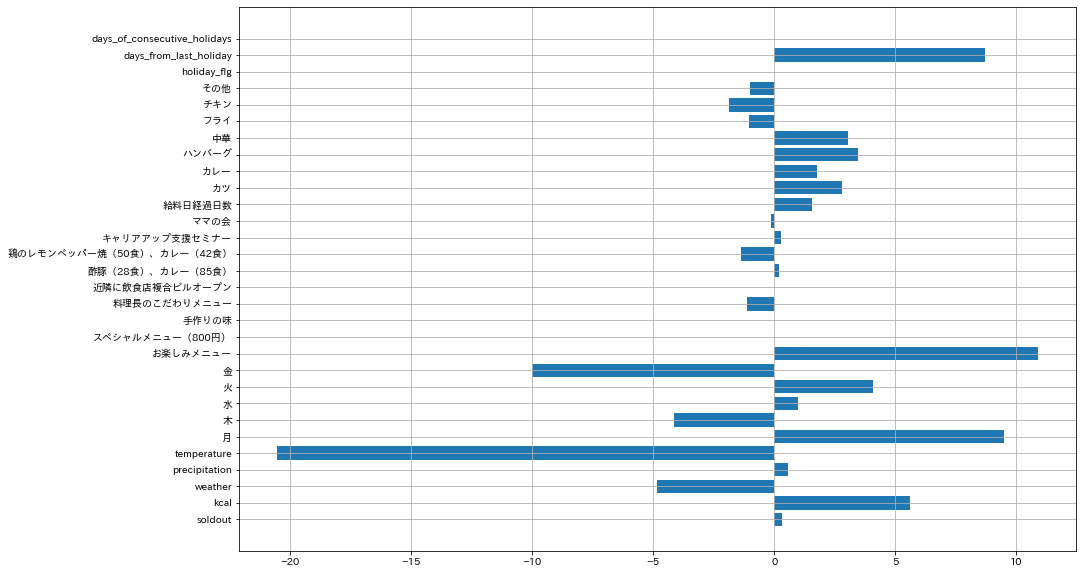

In [62]:
plt.subplots(figsize=(15,10))
x = stem_df.features
y = stem_df.coef

x_position = np.arange(len(x))
plt.barh(x_position, y, tick_label=x)
plt.grid()
plt.show()

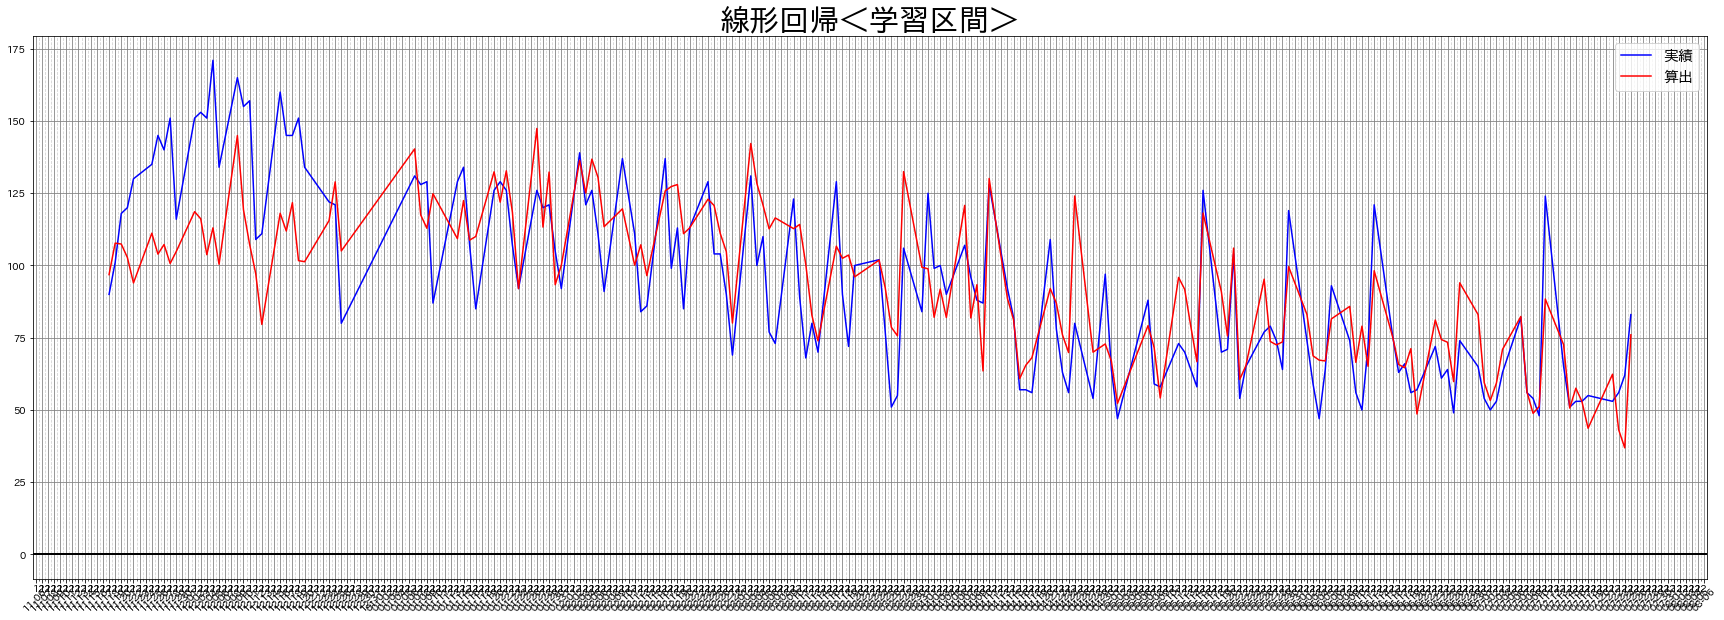

In [63]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_lr, color='red', label='算出')
ax.set_title('線形回帰＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

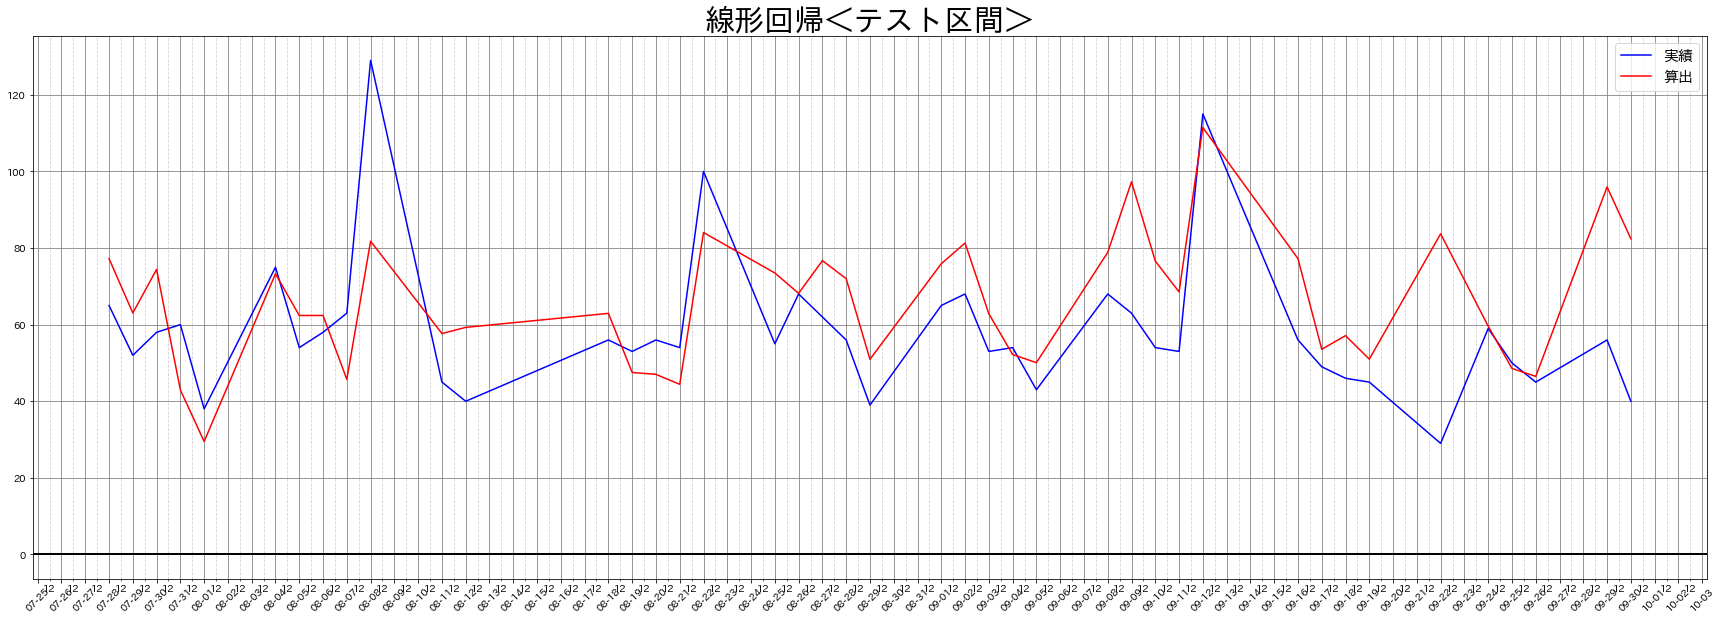

In [64]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_lr, color='red', label='算出')
ax.set_title('線形回帰＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

RMSE

In [65]:
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [66]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_lr)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_lr)))

学習区間：19.68222607042029
テスト区間：18.9288625230872


## ランダムフォレスト回帰

In [67]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split, GridSearchCV

In [68]:
rg = RFR(n_jobs=-1, random_state=19)
rg.fit(X_train_data_scaled, y_train_data)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=19, verbose=0, warm_start=False)

In [69]:
y_pred_train_data_rg = rg.predict(X_train_data_scaled)
y_pred_val_data_rg = rg.predict(X_val_data_scaled)

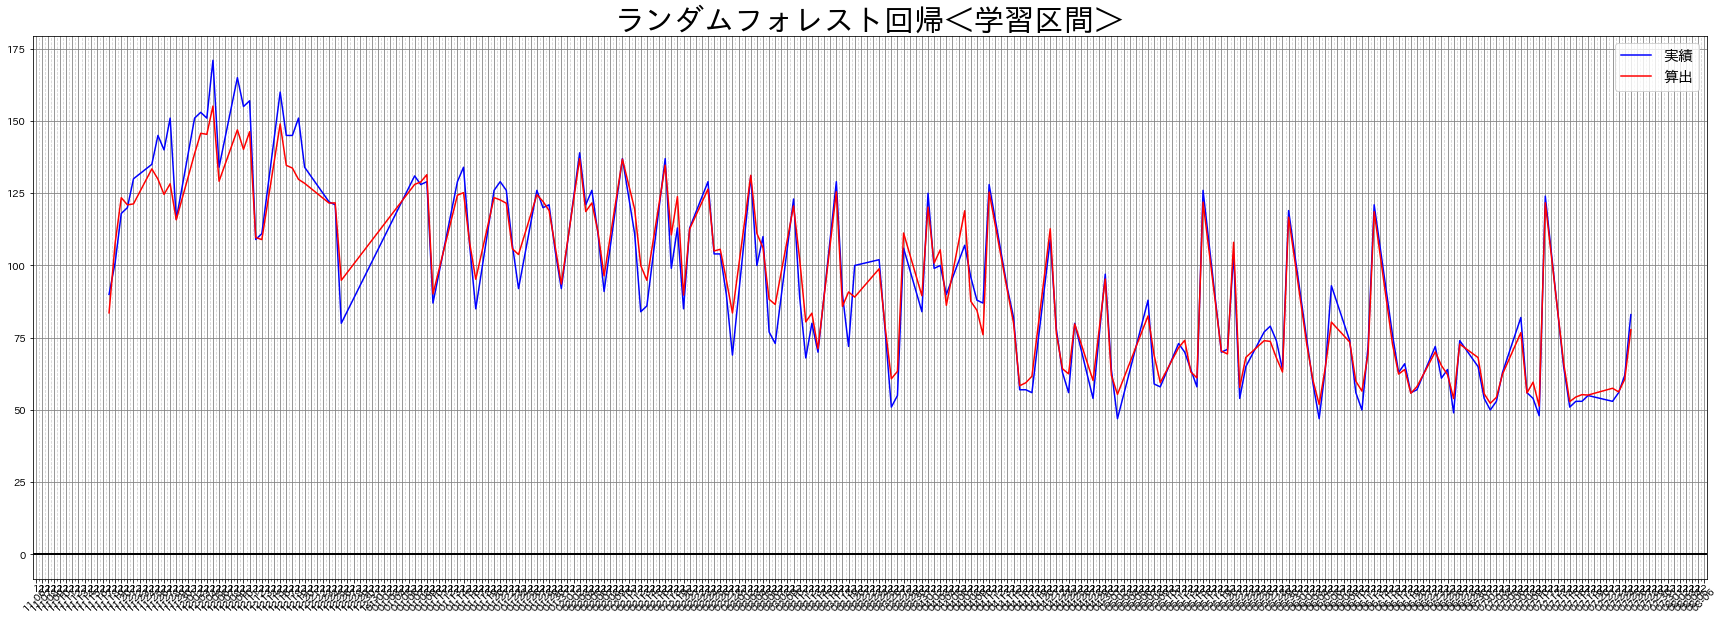

In [70]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

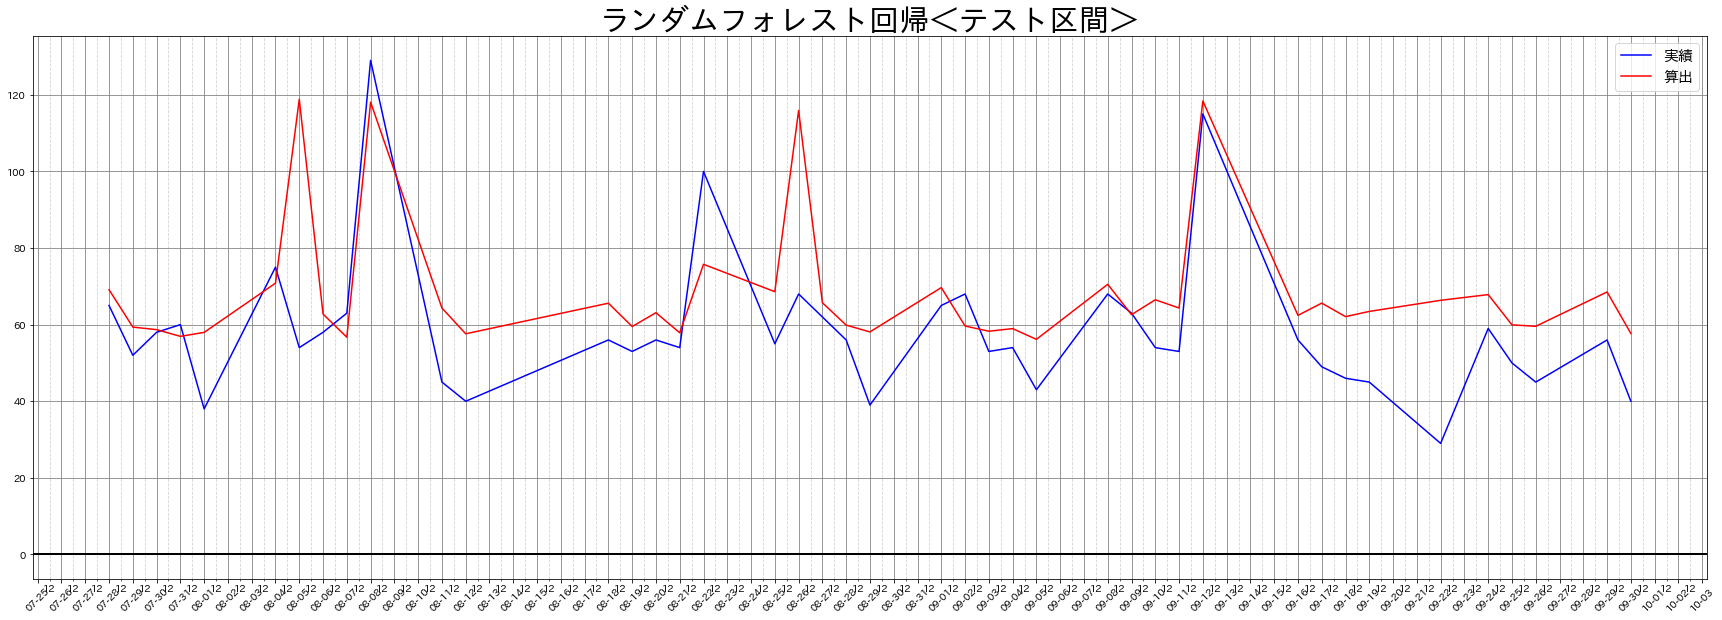

In [71]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

### RMSE

In [72]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_rg)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_rg)))

学習区間：6.882982616349521
テスト区間：17.60622177635211


### ハイパーパラメータチューニング

パラメータについて  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [73]:
search_params = {
    'n_estimators'      : [5, 30, 100, 300], # 木の数
    'random_state'      : [19],
    'min_samples_split' : [2, 10, 30],
    # 'max_depth'         : [None, 1, 2, 3, 30, 100] # Noneが一番いいのにNoneにならない・・・
}
 
gs_rg = GridSearchCV(
    RFR(),
    search_params,
    cv = 3,
    n_jobs = -1,
    verbose=True
)
 
gs_rg.fit(X_train_data_scaled, y_train_data)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [74]:
print(gs_rg.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=19, verbose=0, warm_start=False)


In [75]:
y_pred_train_data_gs_rg = gs_rg.predict(X_train_data_scaled)
y_pred_val_data_gs_rg = gs_rg.predict(X_val_data_scaled)

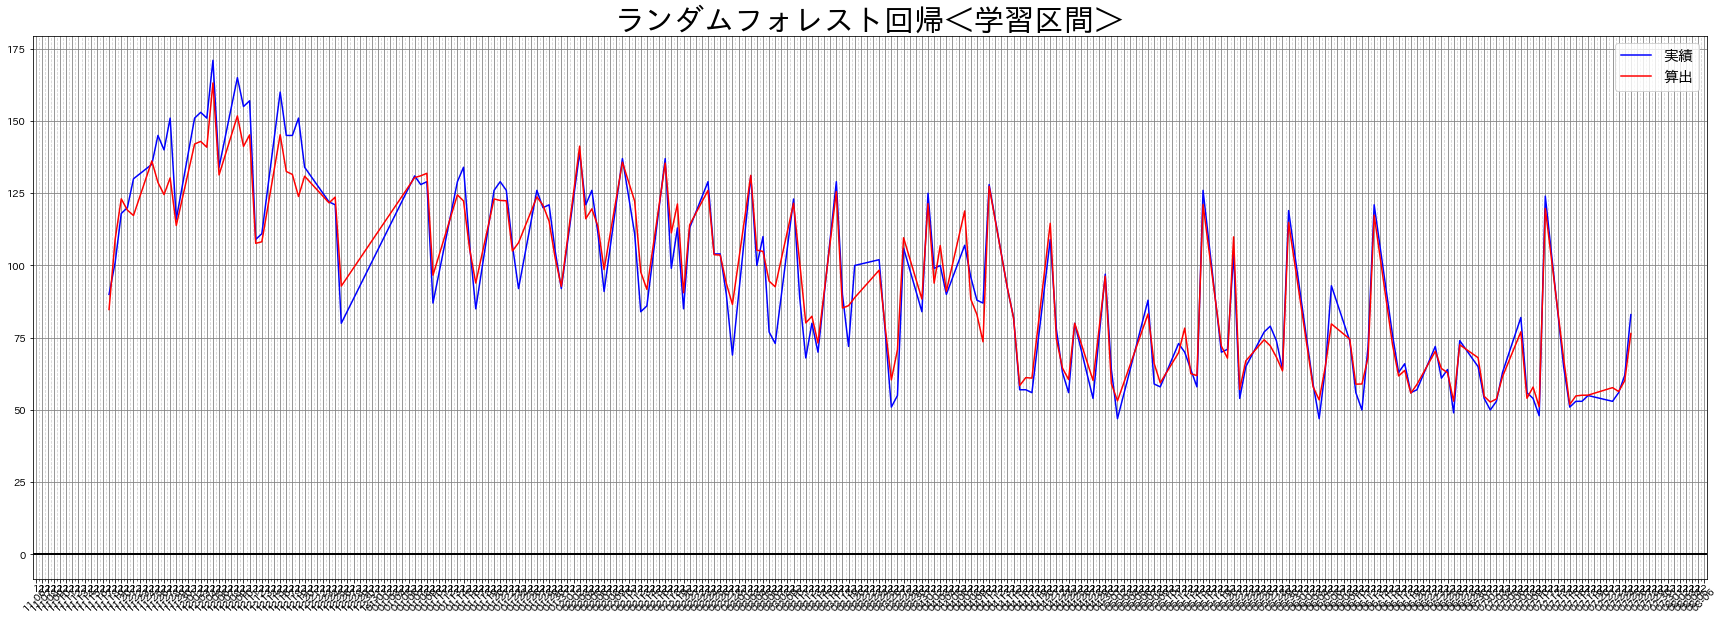

In [76]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_gs_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

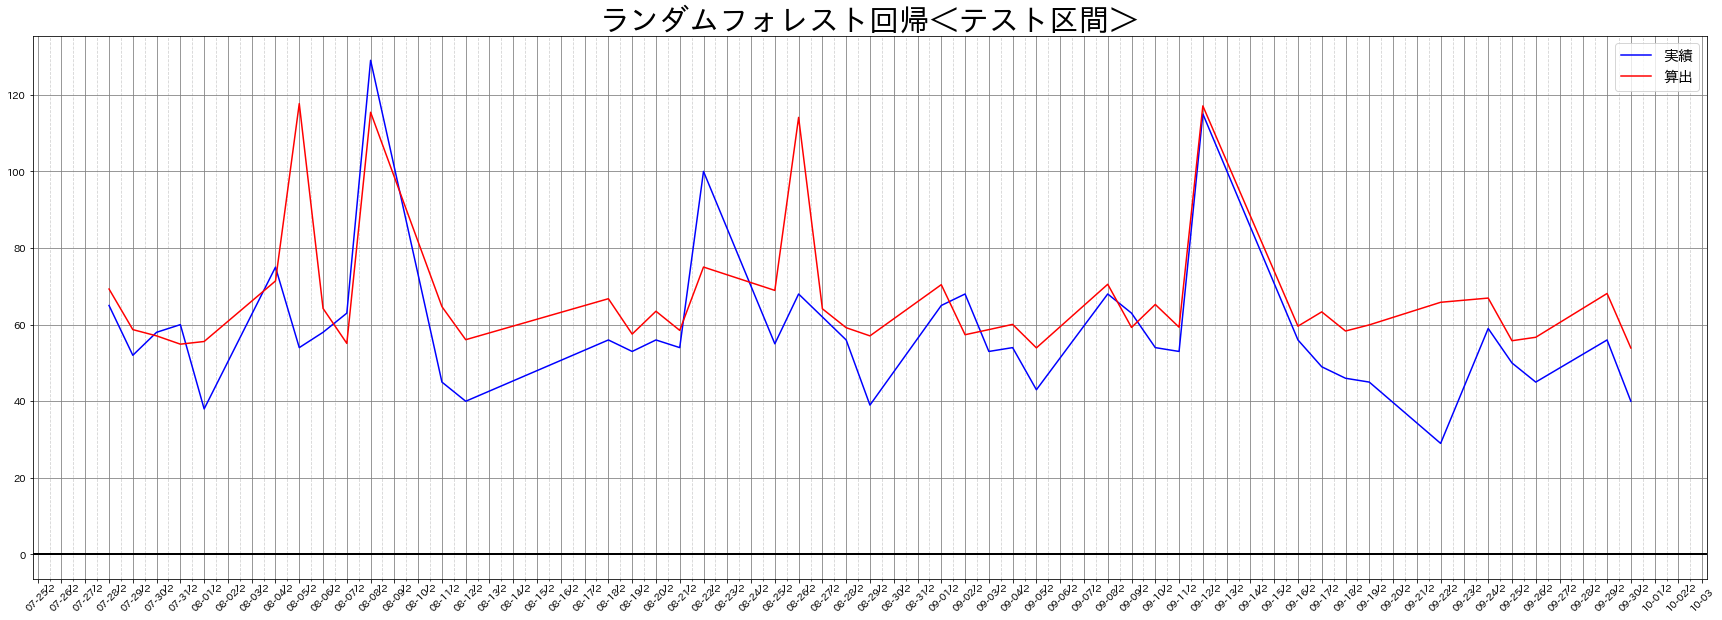

In [77]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_gs_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

### RMSE

In [78]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_gs_rg)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_gs_rg)))

学習区間：7.297192855408412
テスト区間：16.865302034010917


## サポートベクター回帰（SVR）

In [79]:
from sklearn import svm

In [80]:
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [10**i for i in range(-4,3)], 'C': [10**i for i in range(-3, 4)]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

gs_svr = GridSearchCV(svm.SVR(), tuned_parameters, cv=3, scoring="neg_mean_squared_error")
gs_svr.fit(X_train_data_scaled, y_train_data)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [81]:
print(gs_svr.best_estimator_)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [82]:
y_pred_train_data_gs_svr = gs_svr.predict(X_train_data_scaled)
y_pred_val_data_gs_svr = gs_svr.predict(X_val_data_scaled)

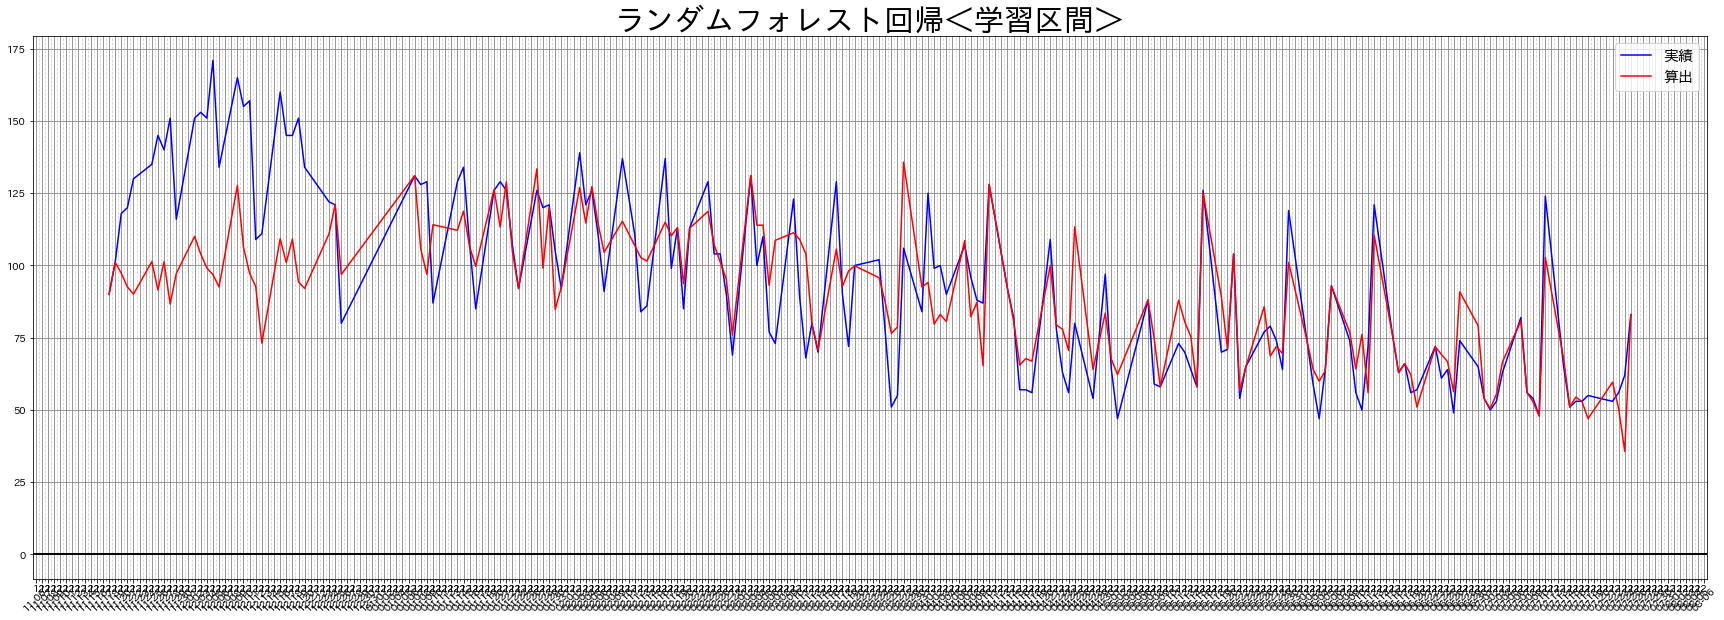

In [83]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_gs_svr, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

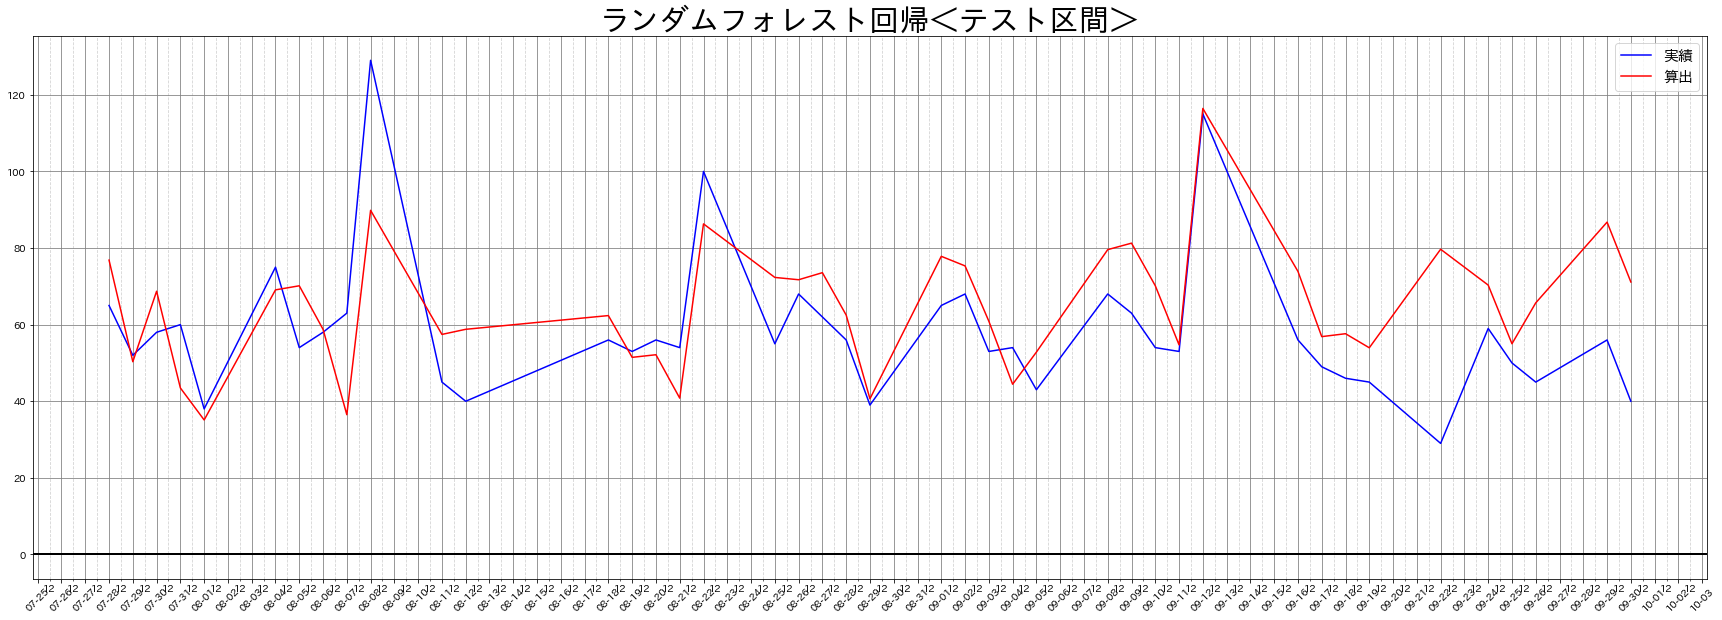

In [84]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_gs_svr, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

### RMSE

In [85]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_gs_svr)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_gs_svr)))

学習区間：20.649401908789073
テスト区間：16.442837913880123


## プロファイルレポート出力

※グラフの表示が変わってしまうので、最後にやる。

In [86]:
# pdp.ProfileReport(train_data_merged, check_correlation=False).to_file(outputfile="ProfileReport_train_data_merged.html")